<a href="https://colab.research.google.com/github/zz2397/PCA-SVD-Autoencoder-Fourier-Wavelet-Transformation-for-denoising/blob/master/Learning_PDE_using_method_of_characteristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!git remote add origin https://github.com/zz2397/Learning-PDE-using-method-of-characteristics-.git
!git branch -M main
!git push -u origin main

error: remote origin already exists.
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/zz2397/Learning-PDE-using-method-of-characteristics-.git'


In [1]:
pip install torchdiffeq

In [2]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
import torchdiffeq
from torchdiffeq import odeint

In [3]:
#Set-up Initial Parameters
#Omega_min, Omega_max are upper and lower bounds of x-domain; T_min, T_max are upper and lower bounds of t-domain
#a, b are coefficients in the form of PDEs: a(x,t,u)u_t + b(x,t,u)u_x = f(x,t,u)

Omega_min = -100
Omega_max = 100
T_min = 0
T_max = 10
a=1
b=2

#batch_time is the length of time-window when using ode-int to solve for batch of solution vector y = (t,x,u)
#number_of_initals are the number of randomly genreated intial datas y_0 = (t0,x0,u0) for solution vector y=(t,x,u)

device = "cpu"
batch_size = 20
batch_time = 10
data_size = 1000
niters = 1000
test_freq = 20
number_of_initials = 1

M = 100
t = torch.linspace(T_min, T_max, data_size).to(device)
x = torch.linspace(0, 1, M).to(device)

In [4]:
#Analytical Formula of true solutiont u:= \int_{0}^{t} f(x-c(t-s)) ds + g(x)
#Here initial-time data of u is u(0,x) =g(x) and we assume u(t,0) = 0 for simplicity in the overleaf doc
#Forcing term is f(x) = sin(x)

def true_solution(t, x, f, c, Ns=100):
    s = torch.linspace(0, torch.max(t).item(), Ns).to(device)
    ds = s[1] - s[0]
    ts = torch.unsqueeze(t, -1) - torch.unsqueeze(s,0)
    return torch.sum((ts >= 0) * f(torch.unsqueeze(s,0), torch.unsqueeze(x,-1) - c*ts), dim=-1) * ds

u_true = lambda t, x: true_solution(t, x, f_true, b, Ns=100)

f_true = lambda t, x: torch.sin(x)


In [5]:
#Generate Initial Data y0

t0s = torch.FloatTensor(number_of_initials, device=device).uniform_(T_min, T_max) # Initialize random times t0
x0s = torch.FloatTensor(number_of_initials, device=device).uniform_(Omega_min, Omega_max) # Initialize random domain points x0
u0s = true_solution(t0s, x0s, f_true, b, Ns=100).to(device) # Initialize heights using true solution

true_y0s = torch.zeros(number_of_initials, 3).to(device)
true_y0s[:, 0] = t0s
true_y0s[:, 1] = x0s
true_y0s[:, 2] = u0s
time_window = t[:batch_time]


In [6]:
#Use ode-int to solve for odes derived from characteristic equations on t=[T_min, T_max] with 1000 discrete points
#dy/ds = (dt/ds, dx/ds, du/ds) = (1,2,f(x))
#get_batch() generates batch of 20 true_y0s , batch_size = 20

class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.cat((a*torch.ones(number_of_initials,1), b*torch.ones(number_of_initials,1),torch.unsqueeze(f_true(y[:,0],y[:,1]),dim=1)),dim=1)

true_y = odeint(Lambda(), true_y0s, t, method='dopri5').to(device)  # Expected shape: (T,N,D)=(1000,1,3), T represents time discretization, N the number of initial points, D the dimension number

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype =np.int64), batch_size, replace=False)) #Randomly select 20 starting time points for 1000 time discrete points
    batch_y0 = true_y[s,:]  # Expected shape, (T, N, D) ; Generate 20 random initial starting time data along ode trajectories
    return batch_y0.to(device)





In [7]:
#Set up Neural Network

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(3, 1),
            #nn.Tanh(),
            #nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    #[Nbatch, Nwindow, 3]
    def forward(self, t, y):
        #During the training process, a batch of data in small time_window will be passed to NN so the shape of y = [T,N,D].
        if len(y.shape) == 3:
            Nbatch, Ninitial_conditions = y.shape[:2]
            f_true_value = f_true(y[:,:,0],y[:,:,1])
            return torch.cat((torch.ones(Nbatch, Ninitial_conditions,1), self.net(y), f_true_value[:,:,None]), dim=2) #NN is restricted to predict x
        #During the training process, the shape of y = [N,D];
        elif len(y.shape) == 2:
            Ninitial_conditions = y.shape[0]
            f_true_value = f_true(y[:,0],y[:,1])
            return torch.cat((torch.ones(Ninitial_conditions,1), self.net(y), f_true_value[:,None]), dim=1)


In [24]:

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


if __name__ == '__main__':

    ii = 0

    func = ODEFunc().to(device)

    optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
    end = time.time()

    time_meter = RunningAverageMeter(0.97)

    loss_meter = RunningAverageMeter(0.97)

    train_loss_list = []
    test_loss_list = []

    for itr in range(1, niters + 1):
        optimizer.zero_grad()

    # Solve ODE for a batch of initial conditions
        batch_y0s = get_batch()
        pred_y = odeint(func,batch_y0s,time_window).to(device)
    # Compute the loss across all trajectories (e.g., L1 loss)
        train_loss = torch.mean(torch.abs(u_true(pred_y[:,:,:,0],pred_y[:,:,:,1])- pred_y[:,:,:,2]))
    # Backpropagation
        train_loss.backward()
        optimizer.step()

    # Update time and loss meters
        time_meter.update(time.time() - end)
        loss_meter.update(train_loss.item())

        if itr % test_freq == 0:

            with torch.no_grad():
                pred_y = odeint(func,true_y0s,t).to(device)
            # Compute the loss across all trajectories (e.g., L1 loss)
                test_loss =  torch.mean(torch.abs(u_true(pred_y[:,:,0],pred_y[:,:,1])- pred_y[:,:,2]))
                print('Iter {:04d} | Test Loss {:.6f}, Train Loss {:.4f}'.format(itr, test_loss.item(), train_loss.item()))
                ii += 1
                test_loss_list.append(test_loss.numpy())
                train_loss_list.append(train_loss.numpy())

    end = time.time()

Iter 0020 | Test Loss 0.292450, Train Loss 0.0344
Iter 0040 | Test Loss 0.294376, Train Loss 0.0360
Iter 0060 | Test Loss 0.300473, Train Loss 0.0327
Iter 0080 | Test Loss 0.272347, Train Loss 0.0333
Iter 0100 | Test Loss 0.245453, Train Loss 0.0299
Iter 0120 | Test Loss 0.321119, Train Loss 0.0388
Iter 0140 | Test Loss 0.248144, Train Loss 0.0326
Iter 0160 | Test Loss 0.339543, Train Loss 0.0365
Iter 0180 | Test Loss 0.336649, Train Loss 0.0331
Iter 0200 | Test Loss 0.342869, Train Loss 0.0251
Iter 0220 | Test Loss 0.277692, Train Loss 0.0325
Iter 0240 | Test Loss 0.262220, Train Loss 0.0292
Iter 0260 | Test Loss 0.313923, Train Loss 0.0291
Iter 0280 | Test Loss 0.272570, Train Loss 0.0307
Iter 0300 | Test Loss 0.356183, Train Loss 0.0388
Iter 0320 | Test Loss 0.306267, Train Loss 0.0359
Iter 0340 | Test Loss 0.270961, Train Loss 0.0340
Iter 0360 | Test Loss 0.354819, Train Loss 0.0284
Iter 0380 | Test Loss 0.345636, Train Loss 0.0297
Iter 0400 | Test Loss 0.351377, Train Loss 0.0324


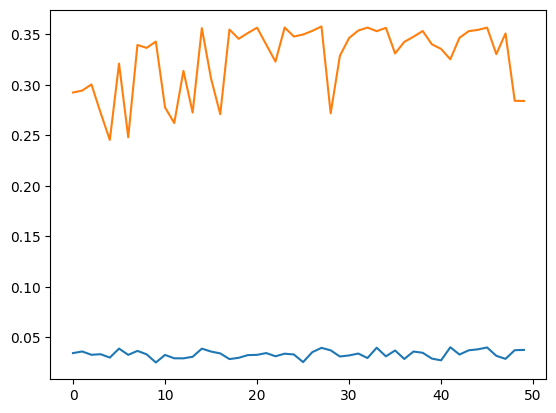

In [27]:
#train loss versus test loss
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.show()

tensor([6.6210])
slope is  tensor([1.0000])


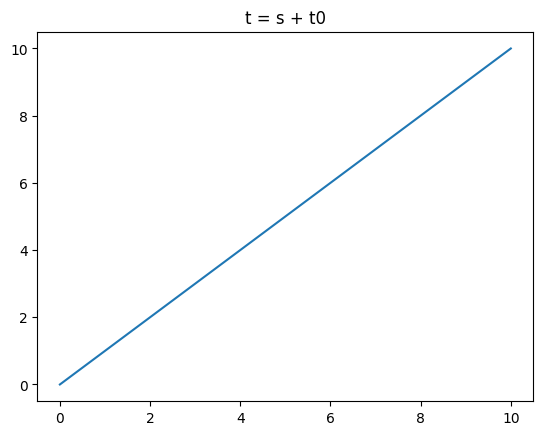

In [28]:
# Plot first tuple of y and print slope of t = s + t0
plt.plot(t, pred_y[:,:,0]-true_y0s[:,0])
plt.title('t = s + t0')
print(true_y0s[:, 0])
print('slope is ',(pred_y[1,:,0]-pred_y[0,:,0])/(t[1]-t[0]) )

slope is  tensor([2.2983])


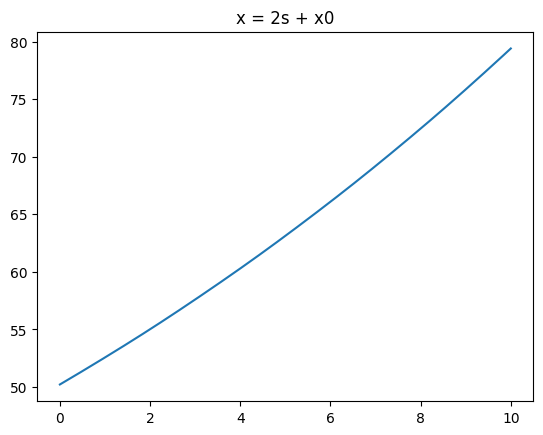

In [30]:
# Plot second tuple of y and print slope of x = 2s + x0
plt.plot(t,pred_y[:,:,1])
plt.title('x = 2s + x0')
print('slope is ',(pred_y[1,:,1]-pred_y[0,:,1])/(t[1]-t[0]) )

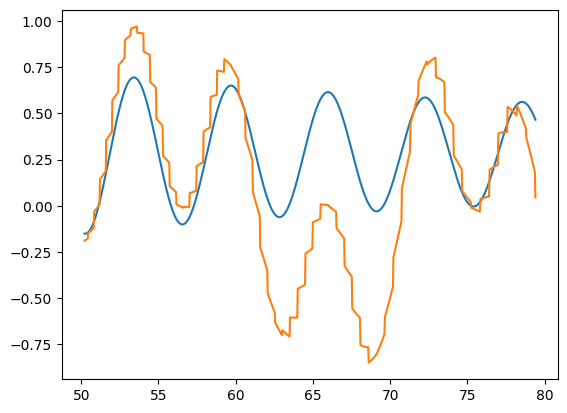

In [32]:
#Plot third tuple of y and see how they converge over time
plt.plot(pred_y[:,:,1], pred_y[:,:,2])
plt.plot(pred_y[:,:,1], u_true(pred_y[:,:,0],pred_y[:,:,1]))
plt.show()

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@9ecbcd8e5080.(none)')
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/zz2397/Learning-PDE-using-metho